<img src="../images/logo.jpg" style="width:85px;height:85px;float:left" /><h1 style="position:relative;float:left;display:inline">Conditional GAN from Scratch</h1>

<a href='https://colab.research.google.com/github/zurutech/gans-from-theory-to-production/blob/master/2.%20GANs%20in%20Tensorflow/BONUS%20-%20Conditional%20GAN%20from%20scratch.ipynb'>
    <img align="left" src='https://cdn-images-1.medium.com/max/800/1*ZpNn76K98snC9vDiIJ6Ldw.jpeg'></img>
</a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
import random

Define the dataset size and the 2 random normal distribution

In [2]:
dataset_shape = (2000, 1)
def sample_z1():
    return tf.random.normal(mean=10., shape=dataset_shape, stddev=0.1, dtype=tf.float32)
def sample_z2():
    return tf.random.normal(mean=20., shape=dataset_shape, stddev=0.2, dtype=tf.float32)

Define the labels for the two distributions

In [3]:
l1 = tf.zeros(shape=(dataset_shape[0],1), dtype=tf.float32)
l2 = tf.ones(shape=(dataset_shape[0],1), dtype=tf.float32)

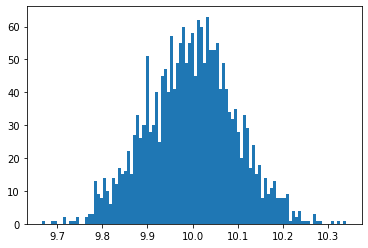

In [4]:
# distribution 1
_ = plt.hist(sample_z1().numpy(), 100)

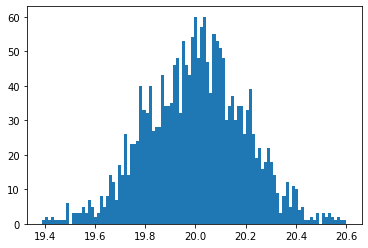

In [5]:
# distribution 2
_ = plt.hist(sample_z2().numpy(), 100)

Define the generator and discriminator functions: both networks accepts a "conditioning" parameter - the label.

In [6]:
def generator(input_shape, condition_shape):
    """generator network.
    Args:
        input_shape: the desired input shape
        condition_shape: the shape of the condition 
    Returns:
        G: The generator model
    """
    inputs = tf.keras.layers.Input(input_shape)
    condition_inputs = tf.keras.layers.Input(condition_shape)
    
    net = tf.keras.layers.Concatenate()([inputs, condition_inputs])
    net = tf.keras.layers.Dense(units=64, activation=tf.nn.elu, name="fc1")(net)
    net = tf.keras.layers.Dense(units=64, activation=tf.nn.elu, name="fc2")(net)
    net = tf.keras.layers.Dense(units=1, name="G")(net)
    G = tf.keras.Model(inputs=[inputs, condition_inputs], outputs=net)
    return G
    
def disciminator(input_shape, condition_shape):
    """discriminator network.
    Args:
        input_shape: the desired input shape
        condition_shape: the shape of the condition
    Returns:
        D: the discriminator model
    """
    inputs = tf.keras.layers.Input(input_shape)
    condition_inputs = tf.keras.layers.Input(condition_shape)
    
    net = tf.keras.layers.Concatenate()([inputs, condition_inputs])
    net = tf.keras.layers.Dense(units=32, activation=tf.nn.elu, name="fc1")(net)
    net = tf.keras.layers.Dense(units=1, name="D")(net)
    D = tf.keras.Model(inputs=[inputs, condition_inputs], outputs=net)
    return D

Define the generator and discriminator - together with the conditional inputs

In [7]:
input_shape = (1,)
condition_shape = (1,)

D = disciminator(input_shape, condition_shape)

latent_space_shape = (100,)
G = generator(latent_space_shape, condition_shape)

Define the discriminator loss

In [8]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

d_loss = lambda real_output, generated_output: bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(generated_output), generated_output)

Define the generator loss

In [9]:
g_loss = lambda generated_output: bce(tf.ones_like(generated_output), generated_output)

Define the train function

In [10]:
def train():
    # Define the optimizers and the train operations
    optimizer = tf.keras.optimizers.Adam(1e-5)
    
    @tf.function
    def train_step():
        for real_data, label  in [(sample_z1(), l1), (sample_z2(), l2)]:
            with tf.GradientTape(persistent=True) as tape:
                noise_vector = tf.random.normal(mean=0, stddev=1, shape=(real_data.shape[0], latent_space_shape[0]))
                # Sample from the Generator
                fake_data = G([noise_vector, label])
                # Compute the D loss
                d_fake_data = D([fake_data, label])
                d_real_data = D([real_data, label])
                d_loss_value = d_loss(generated_output=d_fake_data, real_output=d_real_data)
                # Compute the G loss
                g_loss_value = g_loss(generated_output=d_fake_data)
                tf.print(label[0], "G loss: ", g_loss_value, " D loss: ", d_loss_value)
            # Now that we comptuted the losses we can compute the gradient (using the tape)
            # and optimize the networks
            d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
            g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
            del tape
        
            optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))
            optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
    
    for step in range(40000):
        train_step()
        display.clear_output(wait=True)
train()

[0] G loss:  0.693629861  D loss:  1.38611889
[1] G loss:  0.693625748  D loss:  1.38628697


In [11]:
real_data = sample_z1()
noise_vector = tf.random.normal(mean=0, stddev=1, shape=(real_data.shape[0], latent_space_shape[0]))

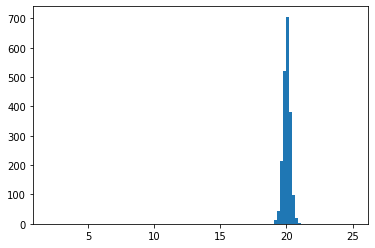

In [12]:
sampled = tf.squeeze(G([noise_vector, l2]))

_ = plt.hist(sampled, 100, range=(2, 25))

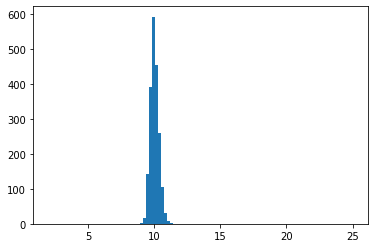

In [13]:
sampled = tf.squeeze(G([noise_vector, l1]))

_ = plt.hist(sampled, 100, range=(2, 25))